# Using Atlite to retrieve global historical data and conversion to power generation potentials

- Atlite documented in https://joss.theoj.org/papers/10.21105/joss.03294

- The shape file for the 27 Eskom supply regions of South Africa is used from PyPSA-ZA bundle
- A cutout with spatio-temporal bounds given by extent of the regions at hourly intervals for the year 2012
- Cutout is prepared, an exclusion container is used to exclude SAPAD and SACAD regions obtained from EGIS website
- Cut out is converted to potentials and time series for solar PV

# Inputs


In [1]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import atlite

from shapely.ops import unary_union

In [4]:
RSA_shapefile = gpd.read_file('../data/supply_regions/supply_regions_RSA.shp') 


RSA = gpd.GeoDataFrame(RSA_shapefile)
#SA = gpd.GeoDataFrame(RSA).set_index(RSA.Name)
RSA = RSA.rename(columns={0: "geometry"}).set_geometry("geometry")

bounds = RSA.unary_union.buffer(1).bounds
cutout = atlite.Cutout(
    path='../cutouts/supply-regions-RSA-2012.nc', 
    module='era5', 
    bounds=bounds, 
    time=slice('2012-01-01', '2013-01-01'))

2022-11-15 14:56:37,947 INFO Building new cutout ../cutouts/supply-regions-RSA-2012.nc


In [3]:
cutout.prepare()

2022-11-15 14:56:26,542 INFO Requesting data for feature temperature...
2022-11-15 14:56:26,545 INFO Requesting data for feature wind...
2022-11-15 14:56:26,546 INFO Requesting data for feature influx...


KeyboardInterrupt: 

In [ ]:
# Create exclusion container to exclude SAPAD and SACAD from the shape file. Available area is also
# shown
from atlite import ExclusionContainer

cap_per_sqkm = 1.7
excluder = ExclusionContainer()
#excluder.add_geometry('../data/bundle/SACAD_OR_2017_Q2/SACAD_OR_2017_Q2.shp')
#excluder.add_geometry('../data/bundle/SAPAD_OR_2017_Q2/SAPAD_OR_2017_Q2.shp')
excluder.add_raster('../data/bundle/SALandCover_OriginalUTM35North_2013_GTI_72Classes/sa_lcov_2013-14_gti_utm35n_vs22b.tif')

availability_matrix = cutout.availabilitymatrix(RSA.to_crs(excluder.crs),excluder)

area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape),
                        [cutout.coords['y'], cutout.coords['x']])
potential = availability_matrix * area * cap_per_sqkm

capacity_factor = cutout.pv(panel='CSi', orientation='latitude_optimal',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm

In [ ]:
resarea = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp').to_crs('EPSG:4326')
resarea = resarea.set_index("Name").rename_axis("redz")
bounds= []
for ind in resarea.index:
    bounds = resarea['geometry'][ind].bounds

cutout = atlite.Cutout(
    path='../cutouts/redz-7-2012.nc', 
    module='era5', 
    x=slice(20.65858615900001,22.39473023800006), 
    dx=0.1,
    dy=0.1,
    y=slice(-29.40532255699998,-28.25956469699999),
    time=slice('2013-01-01', '2013-12-31'))


In [ ]:
cutout.prepare()

In [ ]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt

cutout = atlite.Cutout('../cutouts/redz-7-2012.nc')
regions = gpd.read_file('../resources/onshore_shapes_9-supply.geojson')
regions = regions.set_index("name").rename_axis("bus")
buses = regions.index
resarea = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp').to_crs('EPSG:4326')
resarea = resarea.set_index("Name").rename_axis("redz")
excluder = atlite.ExclusionContainer(crs=3035)
excluder.add_raster('../resources/natura.tiff',nodata=0, allow_no_overlap=True)

In [6]:
availability = cutout.availabilitymatrix(resarea,excluder)

NameError: name 'resarea' is not defined

NameError: name 'availability' is not defined

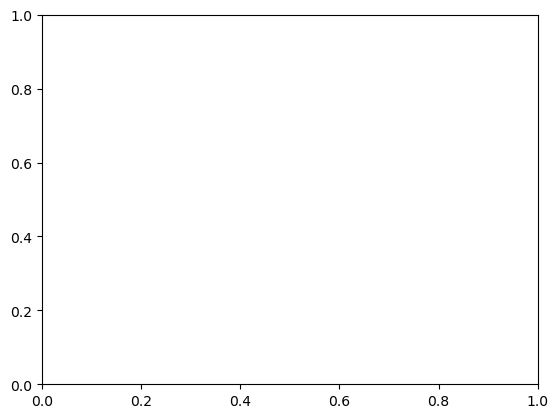

In [5]:
fig, ax = plt.subplots()
availability.sel(redz='Upington - REDZ7').plot(cmap='Greens')
regions.plot(ax=ax, edgecolor='k', color='None')
resarea.plot(ax=ax, edgecolor='r', color='None')
cutout.grid.plot(ax=ax, color='None', edgecolor='grey', ls=':')

In [ ]:
import xarray as xr
area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(
    area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
)
potential = 5*availability.sum("redz")*area 
fig, ax = plt.subplots()
potential.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

In [ ]:
capacity_factor = 0.93 * cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
fig, ax = plt.subplots()
capacity_factor.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

In [ ]:
layout = capacity_factor * area * 5
fig, ax = plt.subplots()
layout.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

In [ ]:
profile, capacities = cutout.wind(turbine='Vestas_V112_3MW',
    matrix=availability.stack(spatial=["y", "x"]),
    layout=layout,
    index=resarea.index,
    per_unit=True,
    return_capacity=True,
)

In [ ]:
capacities.to_pandas()/1e3

In [ ]:
import pypsa
n = pypsa.Network('../networks/elec_za-original_9-supply_redz_LC.nc')

In [ ]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt

In [144]:
cutout = atlite.Cutout('../cutouts/RSA-2013-era5.nc')
regions = gpd.read_file('../resources/onshore_shapes_9-supply.geojson')
regions = regions.set_index("name").rename_axis("bus")
buses = regions.index
resarea = gpd.read_file('../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp').to_crs('EPSG:4326')
resarea = resarea.set_index("Name").rename_axis("redz")
excluder = atlite.ExclusionContainer(crs=3035)
#excluder.add_raster('../resources/natura.tiff',nodata=0, allow_no_overlap=True)
#excluder.add_raster('../resources/landuse_without_protected_conservation.tiff',invert=True,buffer=1)

#excluder.add_geometry(resarea.geometry,invert=True)

In [ ]:
(80530-resarea.Area.sum())/(80530)*100

In [179]:
availability = cutout.availabilitymatrix(resarea,excluder)

Compute availability matrix: 100%|██████████| 8/8 [00:00<00:00, 39.58 gridcells/s]


<AxesSubplot: title={'center': 'redz = Springbok - REDZ8'}, xlabel='x', ylabel='y'>

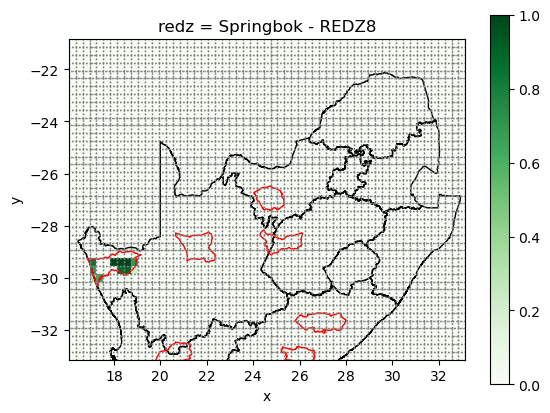

In [234]:
fig, ax = plt.subplots()
availability2.sel(redz='Springbok - REDZ8').plot(cmap='Greens')
regions.plot(ax=ax, edgecolor='k', color='None')
resarea.plot(ax=ax, edgecolor='r', color='None')
cutout.grid.plot(ax=ax, color='None', edgecolor='grey', ls=':')

In [238]:
layout2


<xarray.DataArray (redz: 8, spatial: 2337)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * redz     (redz) object 'Stormberg - REDZ4' ... 'Upington - REDZ7'
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 -33.0 -33.0 -33.0 -33.0 ... -21.0 -21.0 -21.0
  * x        (spatial) float64 16.2 16.5 16.8 17.1 17.4 ... 32.1 32.4 32.7 33.0

<AxesSubplot: xlabel='x', ylabel='y'>

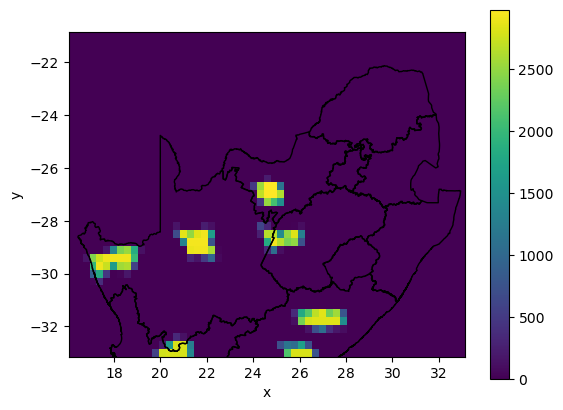

In [219]:
import xarray as xr
area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(
    area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
)
potential = 3*availability.sum("redz")*area 
fig, ax = plt.subplots()
potential.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

<AxesSubplot: xlabel='x', ylabel='y'>

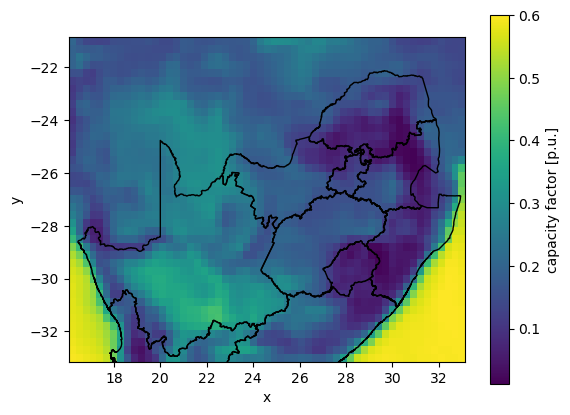

In [161]:
capacity_factor = cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
fig, ax = plt.subplots()
capacity_factor.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

In [ ]:
correction_factor = 1
capacity_per_sqm = 3
capacity_factor = correction_factor * cutout.wind(turbine='Vestas_V112_3MW',capacity_factor=True)
thresh_hold = capacity_factor.where(capacity_factor.values>0.3)

In [ ]:
th = thresh_hold.to_pandas()
b=th.get(0.1)

pointsX=[]
pointsY=[]
for i in th.index:
    for j in th.columns:
        pointsX.append(i)
        pointsY.append(j)
#indices = np.where(df['colB'] == 100)

In [187]:
availability2=availability.copy()

In [189]:
cf = capacity_factor.to_pandas()
cf[cf>0.3] = 1
cf[cf<=0.3] = 0
for redz_loc in range(0,len(availability.coords['redz'])):
    availability2.values[redz_loc,:,:] = np.multiply(availability.values[redz_loc,:,:],cf)

In [242]:
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(
    area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
)

In [246]:
availability2

<xarray.DataArray (redz: 8, y: 41, x: 57)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * redz     (redz) object 'Stormberg - REDZ4' ... 'Upington - REDZ7'
  * y        (y) float64 -33.0 -32.7 -32.4 -32.1 ... -21.9 -21.6 -21.3 -21.0
  * x        (x) float64 16.2 16.5 16.8 17.1 17.4 ... 31.8 32.1 32.4 32.7 33.0

In [244]:
layout2=availability2.stack(spatial=['y', 'x']) * area * 1.7

ValueError: cannot re-index or align objects with conflicting indexes found for the following coordinates: 'y' (2 conflicting indexes), 'x' (2 conflicting indexes)
Conflicting indexes may occur when
- they relate to different sets of coordinate and/or dimension names
- they don't have the same type
- they may be used to reindex data along common dimensions

In [228]:
layout2

<xarray.DataArray (redz: 8, spatial: 2337)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * redz     (redz) object 'Stormberg - REDZ4' ... 'Upington - REDZ7'
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 -33.0 -33.0 -33.0 -33.0 ... -21.0 -21.0 -21.0
  * x        (spatial) float64 16.2 16.5 16.8 17.1 17.4 ... 32.1 32.4 32.7 33.0

In [232]:
profile, capacities = cutout.wind(turbine='Vestas_V112_3MW',
    matrix=availability2.stack(spatial=["y", "x"]),
    layout=layout,
    index=resarea.index,
    per_unit=True,
    return_capacity=True,
)

In [233]:
profile.to_pandas().mean()

redz
Stormberg - REDZ4    0.227006
Komsberg - REDZ2     0.275415
Cookhouse - REDZ3    0.202638
Springbok - REDZ8    0.279721
Kimberley - REDZ5    0.204730
Overberg - REDZ1     0.000000
Vryburg - REDZ6      0.214765
Upington - REDZ7     0.259204
dtype: float64

In [ ]:
capacities.to_pandas()/1e6

In [ ]:
availability.where(capacity_factor["x", "y"]>0.0)

In [ ]:
layout = capacity_factor * area * 3
fig, ax = plt.subplots()
layout.plot(ax=ax)
regions.plot(ax=ax, edgecolor='k', color='None')

In [207]:
layout

<xarray.DataArray (y: 41, x: 57)>
array([[2798.37708144, 2798.37707986, 2798.37707819, ..., 2798.37687749,
        2798.37687119, 2798.37686479],
       [2807.67421509, 2807.67421354, 2807.6742119 , ..., 2807.67401501,
        2807.67400884, 2807.67400256],
       [2816.89404571, 2816.89404418, 2816.89404258, ..., 2816.89384936,
        2816.89384331, 2816.89383715],
       ...,
       [   0.        , 3095.67313328, 3095.6731322 , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [3108.04299989,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])
Coordinates:
  * x        (x) float64 16.2 16.5 16.8 17.1 17.4 ... 31.8 32.1 32.4 32.7 33.0
  * y        (y) float64 -33.0 -32.7 -32.4 -32.1 ... -21.9 -21.6 -21.3 -21.0
    lon      (x) float64 16.2 16.5 16.8 17.1 17.4 ... 31.8 32.1 32.4 32.7 33.0
    lat      (y) float64 -33.0 -32.7 -32.4 -32.1 ... -21.9 -21.6 -21.3 -21.0

In [107]:
profile, capacities = cutout.wind(turbine='Vestas_V112_3MW',
    matrix=availability.stack(spatial=["y", "x"]),
    layout=layout,
    index=resarea.index,
    per_unit=True,
    return_capacity=True,
)

NameError: name 'layout' is not defined

In [ ]:
(availability @ area).to_pandas()

In [ ]:
p_nom_max = 3 * availability @ area

In [ ]:
p_nom_max.to_pandas()/1e3

In [ ]:
capacity_factor

In [ ]:
capacity 

In [ ]:
capacity_factor.where(availability != 0).max(["x", "y"])

In [ ]:
for t in atlite.windturbines: print(f'* {t}')

In [ ]:
fg = availability.plot(row='redz', col_wrap=3, cmap='Greens')
fg.set_titles('{value}')
for i, c in enumerate(resarea.index):
    resarea.loc[[c]].plot(ax=fg.axes.flatten()[i], edgecolor='k', color='None')

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio, rasterio.features, rasterio.mask
import rasterstats
import shapely.geometry
from vresutils import Dict
from snakemake.rules import expand
import yaml
snakemake = Dict()

snakemake.wildcards = Dict(model_file='IRP-2019',
                            tech='wind',
                            regions='9-supply',
                            resarea='redz',
                            ll='copt',
                            opts='LC',
                            attr='p_nom')
snakemake.input = Dict(landuse = "../resources/landuse_without_protected_conservation.tiff".format(**snakemake.wildcards),
                        supply_regions = "../data/supply_regions/supply_regions_{regions}.shp".format(**snakemake.wildcards),
                        resarea = '../data/bundle/REDZ_DEA_Unpublished_Draft_2015/REDZ_DEA_Unpublished_Draft_2015.shp')
snakemake.output = Dict(raster = "../resources/raster_{tech}_percent_{regions}_{resarea}.tiff".format(**snakemake.wildcards),
                        area = "../resources/area_{tech}_{regions}_{resarea}.csv".format(**snakemake.wildcards))

import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake.config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


if snakemake.wildcards.regions == 'RSA':    # Solve available area in 10 or 27 supply regions and then sum to RSA to save memory
    RSA_flag=True
    snakemake.wildcards.regions='10-supply'
    snakemake.input.supply_regions = "../data/supply_regions/supply_regions_10-supply.shp"              
else:
    RSA_flag=False

area_crs = snakemake.config["crs"]["area_crs"]

# Translate the landuse file into a raster of percentages of available area
landusetype_percent = snakemake.config['respotentials']['landusetype_percent'][snakemake.wildcards.tech]


In [ ]:
src = rasterio.open(snakemake.input.landuse)
dst = rasterio.open(snakemake.output.raster, 'w', **src.meta)

resareas = gpd.read_file(snakemake.input.resarea).to_crs(src.crs)
regions = gpd.read_file(snakemake.input.supply_regions).to_crs(src.crs)

stats = []

for region in regions.itertuples():
    resareas_b = resareas.intersects(region.geometry)
    if not resareas_b.any():
        dst.write_band(1, dst_data, window=window)
        stats.append({'mean': 0.})
        continue

    minx, miny, maxx, maxy = region.geometry.bounds
    minx -= (maxx - minx)*0.05
    maxx += (maxx - minx)*0.05
    miny -= (maxy - miny)*0.05
    maxy += (maxy - miny)*0.05

    window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, src.transform)
    box = shapely.geometry.box(minx, miny, maxx, maxy)
    transform = rasterio.windows.transform(window, src.transform)

    src_data = src.read(1, window=window)
    dst_data = np.zeros_like(src_data)

    for grid_codes, value in landusetype_percent:
        dst_data.ravel()[np.in1d(src_data.ravel(), grid_codes)] = value

    mask = rasterio.mask.geometry_mask(resareas.loc[resareas_b, 'geometry'], dst_data.shape, transform)
    dst_data = np.ma.array(dst_data, mask=mask, fill_value=0).filled()

    dst.write_band(1, dst_data, window=window)

    stats.extend(rasterstats.zonal_stats(region.geometry, dst_data, affine=transform,
                                        nodata=-999, stats='mean'))

# stats = pd.DataFrame(stats)

# stats['area_ratio'] = stats.pop('mean') / 100
# stats['area'] = regions.to_crs(area_crs).area/1e6 # albert equal area has area in m^2
# stats['available_area'] = stats['area_ratio'] * stats['area']

# if RSA_flag==True:
#     area_data = stats.sum()
#     area_output = pd.DataFrame(stats.sum(),columns=['RSA']).T
#     area_output.loc['area_ratio'] = area_output['available_area']/area_output['area']
#     area_output.to_csv(snakemake.output.area)
# else:
#     stats.set_index(regions.name).to_csv(snakemake.output.area)